$$ Q^*(s_t, a_t) \approx r + \gamma Q\left(s', \underset{a \in A}{\mathrm{argmax}}\ Q(s', a; \theta_{k}); \theta^{-}_{k}\right) $$

$$ L = \left(Q^*(s_t, a_t) - Q(S_t, A_t) \right)^2 $$


In [5]:
import gymnasium as gym
import torch
import matplotlib.pyplot as plt
import random

from torch import nn
from torch.optim import Adam
from Algorithms.common.replay_buffers import ReplayBuffer
from Algorithms.Agents.DDQN import DDQN

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
"""TODO MAYBE MAKE THE CHOICE BETWEEN DQN AND DDQN BE WITH 
  dqn_agent = Agent('dqn', ...), ddqn_agent = Agent('ddqn', ...)"""


class DQNAgent:

    def __init__(self, _env: gym.envs, use_conv=True, _lr=3e-4, _gamma=0.99, _buffer_size=10000):
        self.env = _env
        self.lr = _lr
        self.gamma = _gamma
        self.epsilon = 1
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        self.replay_buffer = ReplayBuffer(_buffer_size)

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        self.use_conv = use_conv
        # changed from DQN
        self.net = DDQN(_env.observation_space.shape, _env.action_space.n, use_conv=use_conv).to(self.device)
        self.optimizer = Adam(self.net.parameters())
        self.MSE_loss = nn.MSELoss()

    def get_action(self, _state: torch.tensor):  # what is the type of state?
        _state = _state.unsqueeze(0).to(self.device)
        qvals = self.net(_state)
        _action = torch.argmax(qvals).item()
        self.epsilon = max(self.epsilon_min, self.epsilon_decay * self.epsilon)

        return self.env.action_space.sample() if random.random() < self.epsilon else _action

    def compute_loss(self, _batch):
        states, actions, rewards, next_states, terms, truncs = zip(*_batch)
        states = torch.stack(states).to(self.device)
        actions = torch.tensor(actions).to(self.device)
        rewards = torch.tensor(rewards).to(self.device)
        next_states = torch.stack(next_states).to(self.device)
        dones = torch.tensor([terms[i] or truncs[i] for i in range(len(terms))]).float().to(self.device)

        Q_curr = self.net(states).gather(1, actions.unsqueeze(1)).squeeze(1)  # (B)
        Q_target_next = self.net.target_Q_net(next_states).detach().max(1)[0]  # (B, A) # changed from DQN
        Q_target = rewards + self.gamma * Q_target_next * (1 - dones)

        loss = self.MSE_loss(Q_curr, Q_target)
        return loss

    def update(self, _batch_size):
        batch = self.replay_buffer.sample(_batch_size)
        loss = self.compute_loss(batch)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.net.update_target()  # changed from DQN


Episode 0: 13.0
Episode 1: 12.0
Episode 2: 16.0
Episode 3: 29.0
Episode 4: 12.0
Episode 5: 10.0
Episode 6: 12.0
Episode 7: 21.0
Episode 8: 49.0
Episode 9: 14.0
Episode 10: 15.0
Episode 11: 42.0
Episode 12: 18.0
Episode 13: 22.0
Episode 14: 30.0
Episode 15: 46.0
Episode 16: 31.0
Episode 17: 23.0
Episode 18: 35.0
Episode 19: 58.0
Episode 20: 66.0
Episode 21: 89.0
Episode 22: 121.0
Episode 23: 44.0
Episode 24: 80.0
Episode 25: 64.0
Episode 26: 171.0
Episode 27: 56.0
Episode 28: 85.0
Episode 29: 201.0
Episode 30: 84.0
Episode 31: 78.0
Episode 32: 161.0
Episode 33: 126.0
Episode 34: 241.0
Episode 35: 143.0
Episode 36: 128.0
Episode 37: 149.0
Episode 38: 130.0
Episode 39: 210.0
Episode 40: 123.0
Episode 41: 120.0
Episode 42: 159.0
Episode 43: 127.0
Episode 44: 152.0
Episode 45: 215.0
Episode 46: 167.0
Episode 47: 126.0
Episode 48: 210.0
Episode 49: 163.0
Episode 50: 147.0
Episode 51: 236.0
Episode 52: 171.0
Episode 53: 84.0
Episode 54: 13.0
Episode 55: 9.0
Episode 56: 289.0
Episode 57: 12.0


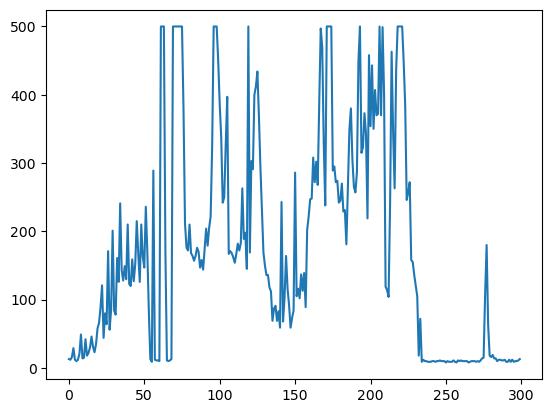

In [7]:
env = gym.make('CartPole-v1')

episode_reward = 0
batch_size = 32
max_episodes = 300
max_steps = 1000

# Initialize your DQN model
agent = DQNAgent(env, use_conv=False)

episode_rewards = []

for episode in range(max_episodes):
    episode_reward = 0
    state = env.reset()[0]
    state = torch.tensor(state, dtype=torch.float32).to(device)

    for step in range(max_steps):
        action = agent.get_action(state)
        next_state, reward, term, trunc, _ = env.step(action)
        next_state = torch.tensor(next_state, dtype=torch.float32).to(device)
        agent.replay_buffer.push(state, action, reward, next_state, term, trunc) # is this the same as pushing them as a tuple? 

        episode_reward += reward

        if len(agent.replay_buffer) > batch_size:
            agent.update(batch_size)

        if term or trunc:
            episode_rewards.append(episode_reward)
            print(f"Episode {episode}: {episode_reward}")
            break

        state = next_state

plt.plot(episode_rewards)

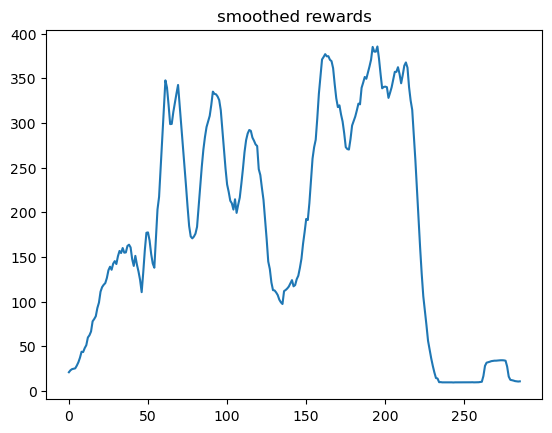

In [10]:
import numpy as np


# Smoothed: 
def moving_average(data, _window_size):
    cumsum_vec = np.cumsum(np.insert(data, 0, 0))
    return (cumsum_vec[_window_size:] - cumsum_vec[:-_window_size]) / _window_size


window_size = 15
smoothed_rew = moving_average(episode_rewards, window_size)
plt.plot(smoothed_rew)
plt.title('smoothed rewards')
plt.show()